In [10]:
from __future__ import print_function
import os.path
import pandas as pd
import sys
sys.path.insert(0, '../..')
%load_ext autoreload
from JKBio import Helper as h
%autoreload 2
%load_ext rpy2.ipython
import numpy as np
from bokeh.plotting import *
from bokeh.models import HoverTool
output_notebook()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from JKBio.helper import pyDESeq2 as pyDESeq2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import MDS, TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
#from umap import UMAP

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


Loading BokehJS ...

In [ ]:
! mkdir ../../data/slam/MYCpaper && cd ../../data/slam/MYCpaper && fastq_dump SRR5806781 && fastq_dump SRR5806783 && fastq_dump SRR5806785 &&
fastq_dump SRR5806780 && fastq_dump SRR5806782 && fastq_dump SRR5806784 && cd -

In [355]:
ls ../../data/slam/MYCpaper

resMYCv3/           SRR5806781_1.fastq  SRR5806783_1.fastq  SRR5806785_1.fastq
SRR5806780_1.fastq  SRR5806782_1.fastq  SRR5806784_1.fastq


In [357]:
folder_bams = "../../data/slam/MYCpaper/"
bams = ! ls $folder_bams
bams

In [390]:
! pip3 install git+https://github.com/jkobject/slamdunk.git --upgrade

  Cloning https://github.com/jkobject/slamdunk.git to /tmp/pip-req-build-efih3o71
  Running setup.py bdist_wheel for slamdunk ... done
  Stored in directory: /tmp/pip-ephem-wheel-cache-fhh0yj8w/wheels/4c/b2/9c/e1153807b1571f6f12ee9761dcf5229ceee161c5c575b631fd
Successfully built slamdunk
  Found existing installation: slamdunk 0.4.0
    Uninstalling slamdunk-0.4.0:
      Successfully uninstalled slamdunk-0.4.0


In [366]:
for val in bams[1:]:
    print(val)
    os.system('../../TrimGalore-0.6.5/trim_galore -stringency 3 \
    --illumina '+folder_bams+val + ' -o '+folder_bams) 

SRR5806781_1.fastq
SRR5806782_1.fastq
SRR5806783_1.fastq
SRR5806784_1.fastq
SRR5806785_1.fastq


In [371]:
ls -al ../../data/slam/res/count

total 8
drwxr-xr-x 2 jeremie jeremie 4096 Feb 13 15:24 ./
drwxr-xr-x 6 jeremie jeremie 4096 Feb 13 15:24 ../


In [368]:
for val in bams[1:]:
    print(val)
    os.system('slamdunk all -r ../../data/slam/ref_genome.fa -b ../../data/slam/GSE100708_hg38_refseq_062016_ensemblv84_3UTR.bed \
    -o ../../data/slam/res/ -t 8 -c 2 '+folder_bams+val.split('.')[0]+'_trimmed.fq')

SRR5806781_1.fastq
SRR5806782_1.fastq
SRR5806783_1.fastq
SRR5806784_1.fastq
SRR5806785_1.fastq


In [373]:
ls -al ../../data/slam/res/filter

total 5351016
drwxr-xr-x 2 jeremie jeremie       4096 Feb 13 17:51 ./
drwxr-xr-x 6 jeremie jeremie       4096 Feb 13 15:24 ../
-rw-r--r-- 1 jeremie jeremie  867853110 Feb 13 15:12 SRR5806781_1_trimmed_slamdunk_mapped_filtered.bam
-rw-r--r-- 1 jeremie jeremie    4061152 Feb 13 15:13 SRR5806781_1_trimmed_slamdunk_mapped_filtered.bam.bai
-rw-r--r-- 1 jeremie jeremie        190 Feb 13 15:13 SRR5806781_1_trimmed_slamdunk_mapped_filtered.log
-rw-r--r-- 1 jeremie jeremie 1376536652 Feb 13 15:54 SRR5806782_1_trimmed_slamdunk_mapped_filtered.bam
-rw-r--r-- 1 jeremie jeremie    4206424 Feb 13 15:55 SRR5806782_1_trimmed_slamdunk_mapped_filtered.bam.bai
-rw-r--r-- 1 jeremie jeremie        190 Feb 13 15:55 SRR5806782_1_trimmed_slamdunk_mapped_filtered.log
-rw-r--r-- 1 jeremie jeremie  881266957 Feb 13 16:31 SRR5806783_1_trimmed_slamdunk_mapped_filtered.bam
-rw-r--r-- 1 jeremie jeremie    4045448 Feb 13 16:31 SRR5806783_1_trimmed_slamdunk_mapped_filtered.bam.bai
-rw-r--r-- 1 jeremie jeremie        1

In [391]:
for val in bams[1:]:
    print(val)
    os.system('slamdunk count -r ../../data/slam/ref_genome.fa \
    -b ../../data/slam/GSE100708_hg38_refseq_062016_ensemblv84_3UTR.bed \
    -o ../../data/slam/res/count/ -t 8 -c 2 -s ../../data/slam/res/snp \
    ../../data/slam/res/filter/'+ val.split('.')[0]+"_trimmed_slamdunk_mapped_filtered.bam")

SRR5806781_1.fastq
SRR5806782_1.fastq
SRR5806783_1.fastq
SRR5806784_1.fastq
SRR5806785_1.fastq


# we first need to recreate out RNA matrix from slamdunk's tcount files

In [414]:
location= '../../data/slam/resMYCpaper/count/*.tsv' # ../data/slamseq_data/

In [415]:
files = ! ls $location
files

['../../data/slam/resMYCpaper/count/SRR5806780_1_trimmed_slamdunk_mapped_filtered_tcount.tsv',
 '../../data/slam/resMYCpaper/count/SRR5806781_1_trimmed_slamdunk_mapped_filtered_tcount.tsv',
 '../../data/slam/resMYCpaper/count/SRR5806782_1_trimmed_slamdunk_mapped_filtered_tcount.tsv',
 '../../data/slam/resMYCpaper/count/SRR5806783_1_trimmed_slamdunk_mapped_filtered_tcount.tsv',
 '../../data/slam/resMYCpaper/count/SRR5806784_1_trimmed_slamdunk_mapped_filtered_tcount.tsv',
 '../../data/slam/resMYCpaper/count/SRR5806785_1_trimmed_slamdunk_mapped_filtered_tcount.tsv']

In [420]:
data={}
for file in files:
    data[file.split('/')[-1].split('_')[0]]= pd.read_csv(file, sep='\t', comment='#',header=0)

In [421]:
files

['../../data/slam/resMYCpaper/count/SRR5806780_1_trimmed_slamdunk_mapped_filtered_tcount.tsv',
 '../../data/slam/resMYCpaper/count/SRR5806781_1_trimmed_slamdunk_mapped_filtered_tcount.tsv',
 '../../data/slam/resMYCpaper/count/SRR5806782_1_trimmed_slamdunk_mapped_filtered_tcount.tsv',
 '../../data/slam/resMYCpaper/count/SRR5806783_1_trimmed_slamdunk_mapped_filtered_tcount.tsv',
 '../../data/slam/resMYCpaper/count/SRR5806784_1_trimmed_slamdunk_mapped_filtered_tcount.tsv',
 '../../data/slam/resMYCpaper/count/SRR5806785_1_trimmed_slamdunk_mapped_filtered_tcount.tsv']

In [422]:
prev = -2
for k,val in data.items():
    if len(set(val.Name)) != prev and prev!=-2: 
        raise ValueError('we do not have the same number of genes in each file')
    prev = len(set(val.Name))

![](images/conversionrates.png)

In [423]:
data.keys()

dict_keys(['SRR5806780', 'SRR5806781', 'SRR5806782', 'SRR5806783', 'SRR5806784', 'SRR5806785'])

In [424]:
val

,Chromosome,Start,End,Name,Length,Strand,ConversionRate,ReadsCPM,Tcontent,CoverageOnTs,ConversionsOnTs,ReadCount,TcReadCount,multimapCount,ConversionRateLower,ConversionRateUpper
0,chr22,29442122,29442455,5988,333,+,0.000000,0.000000,112,0,0,0,0,0,-1.0,-1.0
1,chr19,13961529,13962694,5989,1165,-,0.010501,16.985281,242,13713,144,547,50,0,-1.0,-1.0
2,chr12,109448654,109451813,83892,3159,-,0.009883,31.082754,921,25396,251,1001,83,0,-1.0,-1.0
3,chr12,109456117,109456313,83892,196,-,0.000000,0.000000,57,0,0,0,0,0,-1.0,-1.0
4,chr12,109457629,109457682,83892,53,-,0.000000,0.000000,10,0,0,0,0,0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58131,chr1,46691873,46692098,100130197,225,+,0.000000,0.000000,61,0,0,0,0,0,-1.0,-1.0
58132,chr2,101151659,101152759,100506286,1100,+,0.080000,0.062103,191,25,2,2,1,0,-1.0,-1.0
58133,chr2,101154034,101155412,100506286,1378,+,0.000000,0.186310,337,98,0,6,0,0,-1.0,-1.0
58134,chrX,106639813,106639896,100616144,83,+,0.000000,0.000000,25,0,0,0,0,0,-1.0,-1.0


In [425]:
flag_var= 100

readcounts = {i:[0]*len(data) for i in val.Name.unique()}
tccounts = {i:[0]*len(data) for i in val.Name.unique()}

In [426]:
for n, (_,val) in enumerate(data.items()):
    val = val.sort_values(by="Name")
    j  = 0
    #print('              ',end='\r')
    readcount = [val.iloc[0].ReadCount]
    tccount = [val.iloc[0].TcReadCount]
    prevname = val.iloc[0].Name
    for _, v in val.iloc[1:].iterrows():
        if v.Name==4609:
            print(v.ReadCount,v.TcReadCount)
            print(readcount,tccount)
        if v.Name == prevname:
            readcount.append(v.ReadCount)
            tccount.append(v.TcReadCount)
        else:
            readcounts[prevname][n] = np.sum(readcount)
            tccounts[prevname][n] = np.sum(tccount)
            #if np.var(readcount) > flag_var:
            #    print("pb with "+str(v.Name))
            prevname=v.Name
            j+=1
            #print(j,end='\r')
            readcount = [v.ReadCount]
            tccount = [v.TcReadCount]
            
files = [*data]

3122 2071
[2111, 9] [19, 1]
2459 1601
[1631, 10] [30, 0]
4196 2887
[2798, 10] [66, 0]
1363 918
[1440, 8] [5, 0]
2425 1605
[2573, 6] [14, 0]
1504 1016
[1849, 6] [14, 0]


In [427]:
val.Name

35944            1
14222            2
42459            3
42460            3
42452            3
           ...    
33888    107282092
8628     107303344
7168     107397392
43745    107399301
43744    107399303
Name: Name, Length: 58136, dtype: int64

In [428]:
files

['SRR5806780',
 'SRR5806781',
 'SRR5806782',
 'SRR5806783',
 'SRR5806784',
 'SRR5806785']

In [429]:
readcounts[4609]

[3122, 2459, 4196, 1363, 2425, 1504]

In [430]:
readcounts = pd.DataFrame(data=readcounts,columns=val.Name.unique(),index=data.keys()).T
tccounts = pd.DataFrame(data=tccounts,columns=val.Name.unique(),index=data.keys()).T

In [279]:
readcounts.loc[4609]

MV4-11_1uM_JQ1_rep-1_exp-2      97
MV4-11_1uM_JQ1_rep-2_exp-2     158
MV4-11_1uM_JQ1_rep-3_exp-2     114
MV4-11_5uM_JQ1_rep-1_exp-2      70
MV4-11_5uM_JQ1_rep-2_exp-2      69
MV4-11_5uM_JQ1_rep-3_exp-2      64
MV4-11_DMSO_rep-1_exp-2        497
MV4-11_DMSO_rep-1             3134
MV4-11_DMSO_rep-2_exp-2        304
MV4-11_DMSO_rep-2             2470
MV4-11_DMSO_rep-3_exp-2        672
MV4-11_DMSO_rep-3             4212
MV4-11_JQ1_rep-1              1371
MV4-11_JQ1_rep-2              2439
MV4-11_JQ1_rep-3              1510
Name: 4609, dtype: int64

In [431]:
names, _ = h.convertGenes(readcounts.index.tolist(), from_idtype="entrez_id", to_idtype="symbol")
readcounts.index = names

you need access to taiga for this (https://pypi.org/project/taigapy/)
1118 could not be parsed... we don't have all genes already


In [432]:
names, _ = h.convertGenes(tccounts.index.tolist(), from_idtype="entrez_id", to_idtype="symbol")
tccounts.index = names

you need access to taiga for this (https://pypi.org/project/taigapy/)
1118 could not be parsed... we don't have all genes already


In [433]:
todrop=np.argwhere(tccounts.values.max(1)>0).ravel()
tccounts = tccounts.iloc[todrop]
readcounts = readcounts.iloc[todrop]

In [434]:
todrop=np.argwhere(readcounts.values.max(1)>=10).ravel()
tccounts = tccounts.iloc[todrop]
readcounts = readcounts.iloc[todrop]

In [435]:
tccounts

,SRR5806780,SRR5806781,SRR5806782,SRR5806783,SRR5806784,SRR5806785
NAT1,138,117,180,121,260,141
AAMP,92,91,143,59,153,96
AARS1,46,46,68,27,31,37
ABAT,3,2,8,2,6,3
ABCA1,9,9,24,3,7,8
...,...,...,...,...,...,...
106865373,0,1,1,0,0,0
107080638,1,6,8,2,18,5
107080644,0,0,0,0,1,1
107303344,23,8,11,3,16,11


In [285]:
tccounts = tccounts.apply(lambda x: x+1)

In [167]:
readcounts[readcounts.columns[:-1]] = readcounts[readcounts.columns[:-1]].apply(lambda x: x+1)

## SLAM-seq
All SLAM-seq assays were performed at 60-70% confluency for adherent cells or
60% of the maximum cell density counted on a hemocytometer for suspension cells. 5-7h
prior to each assay, growth medium was aspirated and replaced. Unless stated otherwise,
cells were pre-treated with indicated small molecule inhibitors or 100µM IAA for 30 min
to pre-establish full target inhibition or degradation. Newly synthesized RNA was labeled
for indicated time spans (45 min or 60 min) at a final concentration of 100µM 4-
thiouridine (4sU, Carbosynth). Adherent cells were harvested by direct snap-freezing of
plates on dry ice. Suspension cells were spun down and immediately snap-frozen. RNA
extraction was performed using the RNeasy Plus Mini Kit (Qiagen). 

Total RNA was subjected to alkylation by iodoacetamide (Sigma, 10mM) for 15 min and RNA was repurified by ethanol precipitation. 500ng alkylated RNA were used as input for generating
3’-end mRNA sequencing libraries using a commercially available kit (QuantSeq 3′
mRNA-Seq Library Prep Kit FWD for Illumina and PCR Add-on Kit for Illumina,
Lexogen). Deep sequencing was performed using HiSeq1500 and HiSeq2500 platforms
(Illumina).

In [ ]:
tccounts

# lets look at the similarity accross replicates

we have some outliers, else it seems to make some sense and on average, to be extremelly similar!

In [286]:
tccounts.columns

Index(['MV4-11_1uM_JQ1_rep-1_exp-2', 'MV4-11_1uM_JQ1_rep-2_exp-2',
       'MV4-11_1uM_JQ1_rep-3_exp-2', 'MV4-11_5uM_JQ1_rep-1_exp-2',
       'MV4-11_5uM_JQ1_rep-2_exp-2', 'MV4-11_5uM_JQ1_rep-3_exp-2',
       'MV4-11_DMSO_rep-1_exp-2', 'MV4-11_DMSO_rep-1',
       'MV4-11_DMSO_rep-2_exp-2', 'MV4-11_DMSO_rep-2',
       'MV4-11_DMSO_rep-3_exp-2', 'MV4-11_DMSO_rep-3', 'MV4-11_JQ1_rep-1',
       'MV4-11_JQ1_rep-2', 'MV4-11_JQ1_rep-3'],
      dtype='object')

In [287]:
sorting = [0,1,2,3,4,5,6,8,10,7,9,11,12,13,14]

In [288]:
tccounts.columns[sorting]

Index(['MV4-11_1uM_JQ1_rep-1_exp-2', 'MV4-11_1uM_JQ1_rep-2_exp-2',
       'MV4-11_1uM_JQ1_rep-3_exp-2', 'MV4-11_5uM_JQ1_rep-1_exp-2',
       'MV4-11_5uM_JQ1_rep-2_exp-2', 'MV4-11_5uM_JQ1_rep-3_exp-2',
       'MV4-11_DMSO_rep-1_exp-2', 'MV4-11_DMSO_rep-2_exp-2',
       'MV4-11_DMSO_rep-3_exp-2', 'MV4-11_DMSO_rep-1', 'MV4-11_DMSO_rep-2',
       'MV4-11_DMSO_rep-3', 'MV4-11_JQ1_rep-1', 'MV4-11_JQ1_rep-2',
       'MV4-11_JQ1_rep-3'],
      dtype='object')

In [289]:
tccounts = tccounts[tccounts.columns[sorting]]

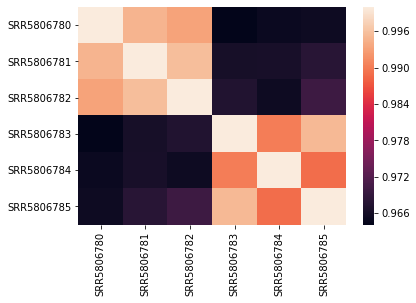

In [436]:
%matplotlib inline
sns.heatmap(tccounts.corr(), 
            xticklabels=tccounts.columns.values,
            yticklabels=tccounts.columns.values)

In [291]:
readcounts = readcounts[readcounts.columns[sorting]]

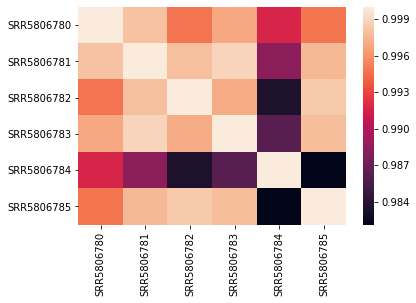

In [437]:
%matplotlib inline
sns.heatmap(readcounts.corr(), 
            xticklabels=readcounts.columns.values,
            yticklabels=readcounts.columns.values)

read the paper for MV411 QC steps.

### A quick detour to look for clustering

## Getting the Core TF information

In [438]:
ctf=pd.read_csv('../data/CTF.csv',header=None)[0].values.tolist()
ctf

['MYC',
 'MYB',
 'SPI1',
 'RUNX1',
 'GSE1',
 'IRF2BP2',
 'FLI1',
 'ELF2',
 'ZEB2',
 'IKAROS',
 'GFI1',
 'LMO2',
 'CEBPA',
 'MEF2D',
 'MEF2C',
 'IRF8',
 'MEIS1',
 'RUNX2',
 'ETV6',
 'LDB1',
 'RUNX2',
 'SP1',
 'ZMYND8']

In [439]:
set(ctf) & set(tccounts.index)

{'CEBPA',
 'ELF2',
 'ETV6',
 'FLI1',
 'GFI1',
 'GSE1',
 'IRF2BP2',
 'IRF8',
 'LDB1',
 'LMO2',
 'MEF2C',
 'MEF2D',
 'MEIS1',
 'MYB',
 'MYC',
 'RUNX1',
 'RUNX2',
 'SP1',
 'SPI1',
 'ZEB2',
 'ZMYND8'}

In [440]:
ctfpos = [val for val in tccounts.index if val in ctf]
notctfpos = [val for val in tccounts.index if val not in ctf]

In [441]:
ctfpos.extend(['EGR1','SERTAD1'])

We find a CTF not in the dataset

# Let's look at how they change accross time

how core transcription factors change accross time when the cell is with JQ1 conditions

we are looking at the difference between production of each CTF compared to the average RNA production with JQ1 and without JQ1

## DESEQ ANALYSIS

In [442]:
readcounts["genes"] = readcounts.index
readcounts = readcounts.reset_index(drop=True)
tccounts["genes"] = tccounts.index
tccounts = tccounts.reset_index(drop=True)

In [294]:
tccounts.iloc[140]

MV4-11_1uM_JQ1_rep-1_exp-2        1
MV4-11_1uM_JQ1_rep-2_exp-2        1
MV4-11_1uM_JQ1_rep-3_exp-2        3
MV4-11_5uM_JQ1_rep-1_exp-2        3
MV4-11_5uM_JQ1_rep-2_exp-2        1
MV4-11_5uM_JQ1_rep-3_exp-2        1
MV4-11_DMSO_rep-1_exp-2           1
MV4-11_DMSO_rep-2_exp-2           1
MV4-11_DMSO_rep-3_exp-2           3
MV4-11_DMSO_rep-1                 4
MV4-11_DMSO_rep-2                 6
MV4-11_DMSO_rep-3                 3
MV4-11_JQ1_rep-1                  1
MV4-11_JQ1_rep-2                  2
MV4-11_JQ1_rep-3                  2
genes                         APBA2
Name: 140, dtype: object

In [295]:
tccounts.columns

Index(['MV4-11_1uM_JQ1_rep-1_exp-2', 'MV4-11_1uM_JQ1_rep-2_exp-2',
       'MV4-11_1uM_JQ1_rep-3_exp-2', 'MV4-11_5uM_JQ1_rep-1_exp-2',
       'MV4-11_5uM_JQ1_rep-2_exp-2', 'MV4-11_5uM_JQ1_rep-3_exp-2',
       'MV4-11_DMSO_rep-1_exp-2', 'MV4-11_DMSO_rep-2_exp-2',
       'MV4-11_DMSO_rep-3_exp-2', 'MV4-11_DMSO_rep-1', 'MV4-11_DMSO_rep-2',
       'MV4-11_DMSO_rep-3', 'MV4-11_JQ1_rep-1', 'MV4-11_JQ1_rep-2',
       'MV4-11_JQ1_rep-3', 'genes'],
      dtype='object')

In [443]:
design = pd.DataFrame(index=[i.replace('-','.') for i in tccounts.columns.values[:-1]], 
                      columns=['DMSO','JQ1'], 
                      data=np.array([[1,1,1,0,0,0],
                                     [0,0,0,1,1,1]],dtype=bool).T)

### Differential gene expression analysis, PCA and GO-term enrichment

For gene-level analysis, raw reads mapped to different UTR annotations of the same gene were summed up by Entrez Gene ID. Pilot studies of K562 cells with kinase inhibitors were performed as single experiments. 

Analysis of differential gene expression was restricted to genes with ≥ 10 reads in at least one condition for 50bp sequencing runs (flavopiridol and DMSO) or ≥ 20 reads in at least one condition for 100bp sequencing runs (mk2206, trametinib, nilotinib, trametinib + mk2206 and DMSO). For estimating differential expression, a pseudo-count of 1 raw read was added to all genes.

#### All other SLAM-seq experiments were performed in triplicates and analyzed as follows. 
Differential gene expression calling was performed on raw read counts with ≥ 2 T>C conversions using DESeq2 (version 1.14.1) with default settings, and with size factors estimated on corresponding total mRNA reads for global normalization.

Downstream analysis was restricted to genes passing all internal filters for FDR estimation by DESeq2. Principal component analysis was performed after variance
stabilizing transformation on the 500 most variable genes across all conditions of a given
experiment. GO-term enrichment analysis was performed on genes significantly and strongly downregulated (FDR ≤ 0.1, log2FC ≤ -1) in SLAM-seq upon IAA-treatment in K562MYC-AID + Tir1 by the PANTHER Overrepresentation Test (Fisher's Exact with FDR multiple test correction, release 20171205, http://pantherdb.org) on GO Ontology database Released 2017-12-27.

In [444]:
design

,DMSO,JQ1
SRR5806780,True,False
SRR5806781,True,False
SRR5806782,True,False
SRR5806783,False,True
SRR5806784,False,True
SRR5806785,False,True


In [445]:
tccounts.columns = [i.replace('-','.') for i in tccounts.columns]

In [446]:
tccounts[tccounts.genes=='MYC']

,SRR5806780,SRR5806781,SRR5806782,SRR5806783,SRR5806784,SRR5806785,genes
1689,2071,1601,2887,918,1605,1016,MYC


In [447]:
deseq = pyDESeq2.pyDESeq2(count_matrix=tccounts[tccounts.columns[np.array([1,1,1,1,1,1,1],np.bool)]],
                         design_matrix=design[np.array([1,1,1,1,1,1],np.bool)],
                         design_formula="~DMSO - JQ1",
                         gene_column="genes")

3.2.6


In [448]:
np.exp(np.mean(np.log(readcounts[readcounts.columns[np.array([1,1,1,1,1,1,0],np.bool)]].values+1), 1))

array([ 554.27123118, 4190.65940299, 2812.89507383, ...,    7.33327055,
        512.80634665,   19.20870683])

In [451]:
deseq.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(
    readcounts[readcounts.columns[np.array([0,0,0,1,1,1,0],np.bool)]].values+1), 1)))

In [452]:
deseq.run_deseq()

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



In [453]:
deseq.get_deseq_result()

In [454]:
JQ1res = deseq.deseq_result

In [455]:
JQ1res.pvalue = np.nan_to_num(np.array(JQ1res.pvalue), 1)
JQ1res.log2FoldChange = np.nan_to_num(np.array(JQ1res.log2FoldChange), 0)

In [456]:
JQ1res[JQ1res.genes=='MYC']

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes
1689,1612.012609,0.714222,0.091909,7.771007,7.786461e-15,2.220295e-12,MYC


In [ ]:
JQ1res.to_csv("data/jq1.mv411.csv")

In [457]:
JQ1res.log2FoldChange = -JQ1res.log2FoldChange

In [458]:
JQ1res["gene_id"] = JQ1res.genes

In [459]:
JQ1res[JQ1res.gene_id=='HNRNPA1']

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
1213,520.380296,-0.718132,0.101307,7.088693,1.353845e-12,3.065662e-10,HNRNPA1,HNRNPA1


In [461]:
show(h.volcano(JQ1res,tohighlight=ctf, searchbox=True))

we can conclude that we get similar results to the slamseq myc paper although it seems that our values are a bit skewed toward higher expression than what is on the slamseq paper. It mightt be explained by the pseudo count of 1 that I did not set. Because I think it would highly bias the DESeq algorithm.